# "Clasificador kNN para CIFAR-10 con tf.numpy"
> Clasificador k-Nearest Neighbor para CIFAR-10, usando la nueva clase experimental tf.numpy. Laboratorio 1 del curso CS231n de Stanford.


- toc: true 
- badges: true 
- comments: true
- categories: ["Computer Vision"]
- image: images/stanford.png



## 1. Introducción

Este ejemplo muestra cómo hacer una clasificación de imágenes usando Machine Learning clásico, sin usar una red convolucional. 
Se va a usar k-Nearest Neighbor y una precisión básica basada en diferencia de pixels. 
Instrucciones originales del [curso de Stanford CS231](https://cs231n.github.io/classification/).  
Este ejemplo se ha probado y funciona en Colab.


## 2. Setup
Importamos las librerías que vamos a usar. usaremos la función experimental `tensorflow.numpy` para aprovechar las GPUs durante operaciones con funciones `numpy` (por ejemplo, durante la inferencia):

In [2]:
!pip3 install --quiet --upgrade tf-nightly


In [27]:
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow.experimental.numpy as np
from sklearn.utils import shuffle

from tensorflow.keras import datasets, layers, models

Comprobamos si tenemos GPUs. En caso contrario, no notaremos diferencia de velocidad:

In [28]:
print("All logical devices:", tf.config.list_logical_devices())
print("All physical devices:", tf.config.list_physical_devices())
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

All logical devices: [LogicalDevice(name='/device:CPU:0', device_type='CPU')]
All physical devices: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]
Num GPUs Available:  0


## 3. Carga de datos
Cargamos el dataset desde `tensorflow.keras.datasets`:

In [29]:
(train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()

# Usando scikit-learn, Hacemos shuffle y usamos sólo 2000 imágenes para entrenar y 100 para test
train_images, train_labels = shuffle(train_images, train_labels)
test_images, test_labels = shuffle(test_images, test_labels)

train_images = train_images[:2000]
train_labels = train_labels[:2000]
test_images = test_images[:100]
test_labels = test_labels[:100]

# Normalizamos valores de píxeles entre 0 y 1
train_images, test_images = train_images / 255.0, test_images / 255.


Visualizamos los primeros 25 elementos del dataset:

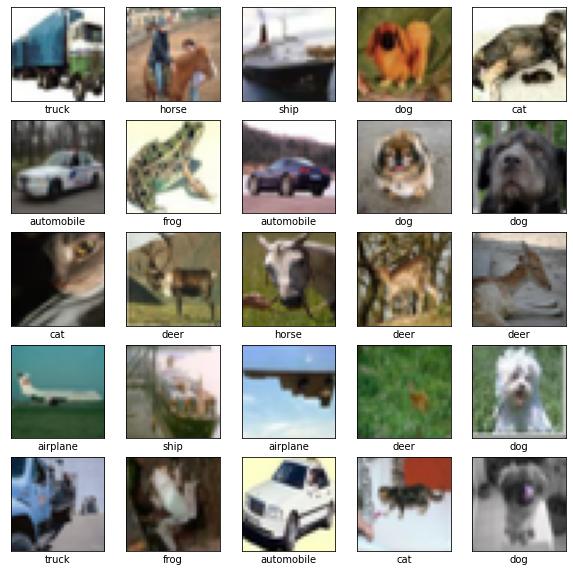

In [30]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap=plt.cm.binary)
    # The CIFAR labels happen to be arrays, 
    # which is why you need the extra index
    plt.xlabel(class_names[train_labels[i][0]])
plt.show()

## 4. Preparar datos
El set de entrenamiento original era de tamaño `train_images.shape=(50000,32,32,3)` y sus etiquetas `train_labels.shape=(50000, 1)`. Pero usamos uno más pequeño de 2000. Aplanamos el set de entrenamiento y también el de pruebas:

In [31]:
train_images_rows = train_images.reshape(train_images.shape[0], 32 * 32 * 3) # train_images_rows.shape 2000 x 3072
test_images_rows = test_images.reshape(test_images.shape[0], 32 * 32 * 3) # test_images_rows.shape 100 x 3072

## 5. Construcción del modelo
Para la predicción, se compara una imagen de test con todas las de entrenamiento, y se devuelve la de menor diferencia (distancia L1: resta de valores de pixels)

In [32]:
class NearestNeighbor(object):
  def __init__(self):
    pass

  def train(self, X, y):
    """ X is N x D where each row is an example. Y is 1-dimension of size N """
    # the nearest neighbor classifier simply remembers all the training data
    self.Xtr = X
    self.ytr = y

  def predict(self, X):
    """ X is N x D where each row is an example we wish to predict label for """
    num_test = X.shape[0]
    # lets make sure that the output type matches the input type
    Ypred = []

    # loop over all test rows
    for i in range(num_test):
      # find the nearest training image to the i'th test image
      # using the L1 distance (sum of absolute value differences)
      distances = np.sum(np.abs(self.Xtr - X[i,:]), axis = 1)
      min_index = np.argmin(distances) # get the index with smallest distance
      Ypred.append(self.ytr[min_index]) # predict the label of the nearest example
      #print("Test image {} of {} is {}".format(i, num_test, Ypred[-1]))


    return Ypred

Para la predicción, se puede usar la distancia L1 ó L2 (cuadrática). Para la diferencia cuadrática, simplemente cambiar la lína anterior por la siguiente: `distances = np.sqrt(np.sum(np.square(self.Xtr - X[i,:]), axis = 1))`


## 6. Entrenamiento y evaluación
Lanzamos el entrenamiento  usando k Nearest Neighbors (kNN). Para la predicción, se calcula la menor diferencia entre la imagen del set de prueba y todas las imágenes de entrenamiento. Se devuelve la etiqueta de la de menor diferencia.

In [33]:
import time
start = time.time()

nn = NearestNeighbor() # create a Nearest Neighbor classifier class
nn.train(train_images_rows, train_labels) # train the classifier on the training images and labels
Yte_predict = nn.predict(test_images_rows) # predict labels on the test images
# and now print the classification accuracy, which is the average number
# of examples that are correctly predicted (i.e. label matches)
print('Accuracy: %f' % ( np.mean(np.array(Yte_predict) == test_labels) ))

end = time.time()
print("Timing", end - start)

Accuracy: 0.420000
Timing 3.5915169715881348
